# Homework #8: Due November 5th, 2020, 11:59pm
## Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:** Assaraf David

**Students collaborators:** Ancel Gael, Pellegrin Raphael

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import autograd.numpy.random as npr
import itertools as it
import sys
%matplotlib inline

In [2]:
class Feedforward:
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']

        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        output = np.matmul(W, input) + b
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):

        def objective(W, t):
            squared_error = np.linalg.norm(y_train - self.forward(W, x_train), axis=1)**2
            if reg_param is None:
                sum_error = np.sum(squared_error)
                return sum_error
            else:
                mean_error = np.mean(squared_error) + reg_param * np.linalg.norm(W)
                return mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

## Problem Description: Bayesian Neural Network Regression
In this homework you will explore Bayeisan models for regression with neural networks -- essentially, you will place priors on the network parameters $\mathbf{W}$ and infer the posterior $p(\mathbf{W}|\text{Data})$. These Bayesian models are called ***Bayesian neural networks***. The data for this regression problem is in `HW8_data.csv`. You are provided an implementation of a neural network as well as an example of how to use it -- but feel free to implement your own version!

In [3]:
#read in the data
data = pd.read_csv('HW8_data.csv')
x_train = data['x'].values.reshape((1, -1))
y_train = data['y'].values.reshape((1, -1))
data.head()

,x,y
0,-6.0,-3.380284
1,-5.6,-2.892117
2,-5.2,-2.690059
3,-4.8,-2.040000
4,-4.4,-1.399942


Let's instantiate a neural network with 1-hidden layer, 5-hidden nodes and `relu` activation:

In [49]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

Fit the neural network to the data and visualize the fit.

In [50]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn.fit(x_train, y_train, params)

Iteration 0 lower bound 1188.2522119587577; gradient mag: 3294.9472005145494
Iteration 100 lower bound 528.2005162282458; gradient mag: 2014.0223481861012
Iteration 200 lower bound 231.71928757081068; gradient mag: 1226.9831178661013
Iteration 300 lower bound 103.99541756891784; gradient mag: 716.7107003654073
Iteration 400 lower bound 55.24716113156889; gradient mag: 376.23346335998286
Iteration 500 lower bound 39.94989749994618; gradient mag: 177.9641773056736
Iteration 600 lower bound 35.60307206137053; gradient mag: 77.19358484414678
Iteration 700 lower bound 34.025856107542445; gradient mag: 38.67687513287844
Iteration 800 lower bound 32.961429361488406; gradient mag: 31.129490339137103
Iteration 900 lower bound 31.989641942996613; gradient mag: 24.752496721932584
Iteration 1000 lower bound 31.082564536611727; gradient mag: 24.616299563320247
Iteration 1100 lower bound 30.155032233758106; gradient mag: 24.248289796695595
Iteration 1200 lower bound 29.210013809597285; gradient mag:

Iteration 10500 lower bound 2.494168018543738; gradient mag: 0.773058738036761
Iteration 10600 lower bound 2.433316490178128; gradient mag: 0.767066193236975
Iteration 10700 lower bound 2.376555349336703; gradient mag: 0.7553579421583901
Iteration 10800 lower bound 2.3238459422563476; gradient mag: 0.7228024683428217
Iteration 10900 lower bound 2.275330834330171; gradient mag: 0.6845211470546975
Iteration 11000 lower bound 2.231249650994422; gradient mag: 0.6413826587052399
Iteration 11100 lower bound 2.191827804434735; gradient mag: 0.5943225261135897
Iteration 11200 lower bound 2.1572058127250573; gradient mag: 0.5444130874954253
Iteration 11300 lower bound 2.1273989093957457; gradient mag: 0.49279021686790947
Iteration 11400 lower bound 2.1022813532268936; gradient mag: 0.44060151668110925
Iteration 11500 lower bound 2.0815910694099786; gradient mag: 0.38895956298850276
Iteration 11600 lower bound 2.0649500999980592; gradient mag: 0.33889610830749123
Iteration 11700 lower bound 2.05

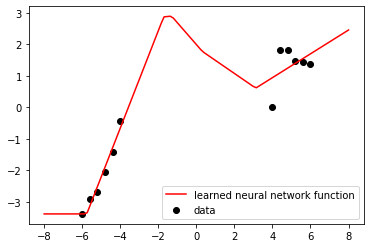

In [51]:
#test x-values
x_test = np.linspace(-8, 8, 100).reshape((1, -1))
#predict on the test x-values
y_test_pred = nn.forward(nn.weights, x_test)
#visualize the function learned by the neural network
plt.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

### Part I: Inference for Bayesian Neural Networks Using HMC

1. (**The Bayesian Neural Network Model**) We will implement the following Bayesian model for the data:<br>
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)\\
\end{align}
where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases).
<br><br>
Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.

In [7]:
#define the log prior on the model parameters
def log_prior(W, Sigma):
    D = Sigma.shape[0]
    constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(np.linalg.det(Sigma)))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, np.linalg.inv(Sigma)), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

#define the log likelihood
def log_lklhd(W, sigma_y):
    N = len(y_train.reshape(-1, 1))
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
    exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - nn.forward(W, x_train))**2, axis=2).flatten()
    return constant + exponential

sigma_diagonal = 25
Sigma = sigma_diagonal*np.eye(nn.D)
sigma_y = 0.5

log_liklhood = lambda w: log_lklhd(w, sigma_y)

#define the log joint density
log_density = lambda w: log_lklhd(w, sigma_y) + log_prior(w, Sigma)
# from target pdf to optimization function
U = lambda w: -log_density(w)  
# gradient of the optmization function
grad_U = grad(U)

2. (**Sample from the Posterior**) Use HMC to sample from the posterior of the Bayesian neural network. Start with the following settings for your sampler:
``` python
params = {'step_size':1e-3, 
          'leapfrog_steps':50, 
          'total_samples':10000, 
          'burn_in':.1, 
          'thinning_factor':2,
          'position_init': nn.weights}
```
  Note that you should initialize with the MLE model, otherwise convergence may be slow. Please feel free to tweak these design choices as you see fit!

In [8]:
def kinetic_energy(p):
    return 1/2*np.dot(np.dot(p, np.linalg.inv(M)), p.T) + 1/2*np.log(np.linalg.det(M)) + p.shape[0]/2*np.log(2*np.pi)

def partial_derivative_K(p):
    return p/m

H = lambda p, q : U(q) + kinetic_energy(p)   #before, tu utilisais K(p), check si c'est good

def simulate_movement(p0, q0, kinetic_energy, potential_energy, step_size, steps):
    p_t, q_t = p0, q0
    for _ in it.repeat(None, steps):
        p_half = p_t - (step_size/2.)*grad_U(q_t)
        q_t = q_t + step_size*partial_derivative_K(p_half)
        p_t = p_half - (step_size/2)*grad_U(q_t)
    p_T = -p_t # reverse momentum
    q_T = q_t
    return p_T, q_T    

def metropolis_hastings(p_current, q_current, p_proposal, q_proposal, kinetic_energy, potential_energy):
    acceptance_rate = min(1, np.exp(H(p_current, q_current) - H(p_proposal, q_proposal)))
    U = np.random.uniform()
    if U <= acceptance_rate:
        return p_proposal, q_proposal
    return p_current, q_current

def Hamiltonian_Monte_Carlo_one_sample(q0, kinetic_energy, potential_energy, step_size, steps):
    p0 = np.random.multivariate_normal(np.zeros(nn.D), M) # kick-off
    p_proposed, q_proposed = simulate_movement(p0, q0,  kinetic_energy, potential_energy, step_size, steps) # movement
    p_mh, q_mh = metropolis_hastings(p0, q0, p_proposed, q_proposed, kinetic_energy, potential_energy) # correct error
    return p_mh, q_mh

#mass 
m = 1
M = m*np.eye(nn.D)
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = nn.weights
#leap-frog step size
step_size = 1e-3
#leap-frog steps
leapfrog_steps = 50
#number of total samples after burn-in
total_samples = 10000  
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 2



qs = [position_init]
for _ in it.repeat(None, total_samples):
    sample = Hamiltonian_Monte_Carlo_one_sample(qs[-1], kinetic_energy, U, step_size, leapfrog_steps)[1]
    qs.append(sample)
    
samples = np.asarray(qs)
burn_in = int(burn_in*total_samples)
samples = samples[burn_in:]
samples = samples[::thinning_factor]

3. (**Visualize the Posterior Predictive**) Visualize 100 samples, randomly selected, from your posterior samples of $\mathbf{W}$, by ploting their predicted values plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a posterior sample of $\mathbf{W}$.

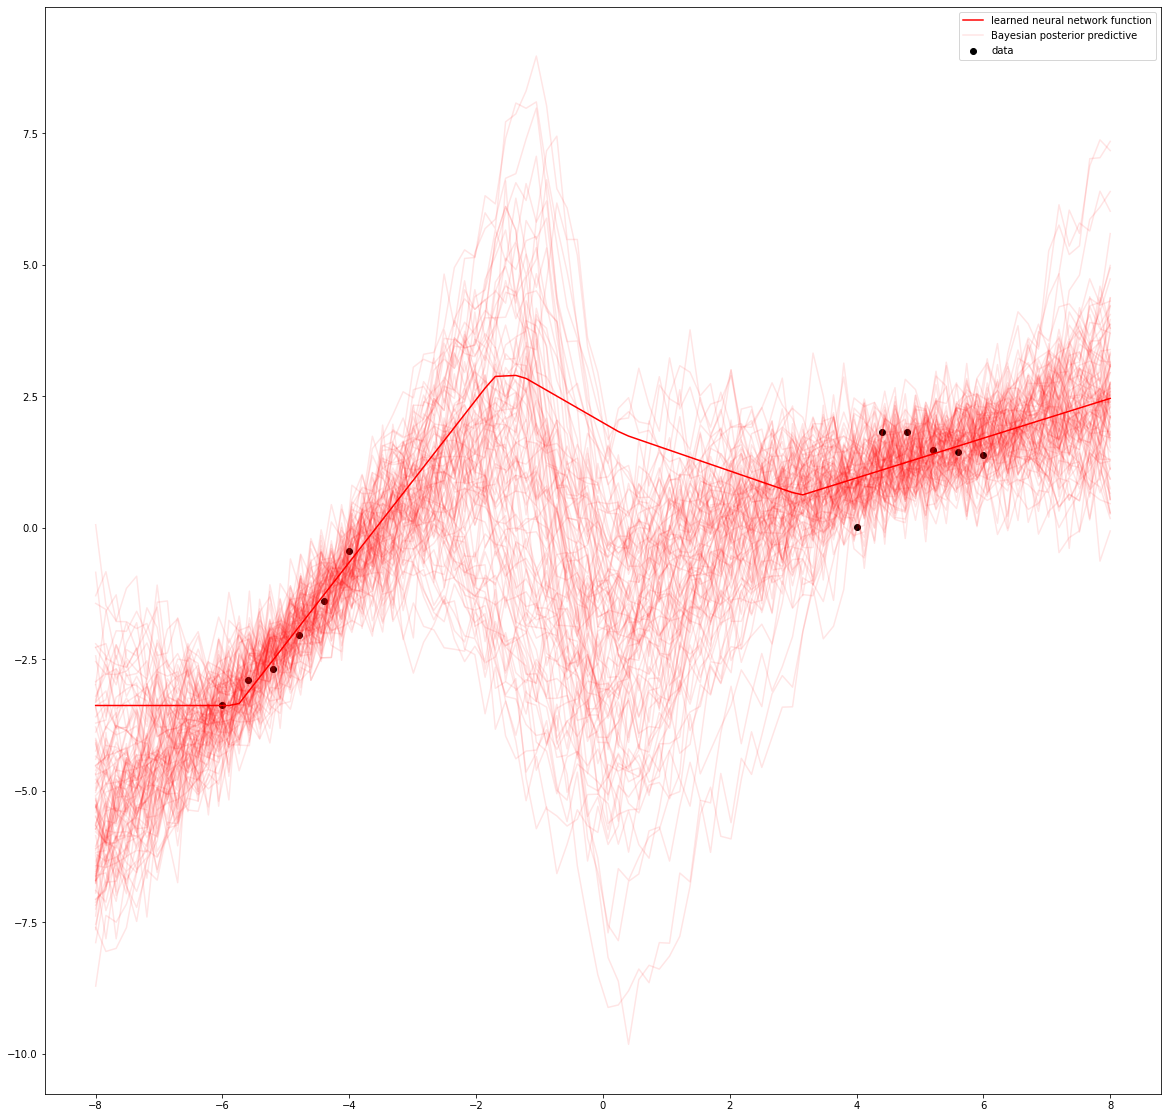

In [9]:
y_test_pred = nn.forward(nn.weights, x_test.reshape((1, -1)))
#visualize the function learned by the neural network
fig, ax = plt.subplots(1, figsize = (20, 20))
ax.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
ax.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
indexes = np.random.choice(len(samples), size=100, replace=False)
for sample in samples[indexes]:
    x_test = np.linspace(-8, 8, 100)
    y_test = nn.forward(sample, x_test.reshape((1, -1))) 
    y_test += np.random.normal(0, 0.5, size=y_test.shape)
    ax.plot(x_test.flatten(), y_test.flatten(), alpha = 0.1, color='red')
ax.plot(x_test.flatten(), y_test.flatten(), alpha = 0.1, color='red', label='Bayesian posterior predictive')
plt.legend(loc='best')
plt.show(fig)

4. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 

  **Note:** Not required for you to worry about for this problem, but note that this is a Monte Carlo estimation of an integral, so you'll need to worry about variance and all that.

$$
  \log \prod_{n=1}^N \int_{W} p(Y^{\text{Obs}}_n | W) p(W|Y^{\text{Obs}}_1, \ldots, Y^{\text{Obs}}_N) dW \approx \sum_{n=1}^N\log \frac{1}{S} \sum_{s=1}^S p(Y^{\text{Obs}}_n | W^s), 
  $$

In [10]:
posterior_predictive_log_likelihood = np.mean([log_liklhood(sample) for sample in samples])
print('The posterior predictive log likelihood of the observed data under your model is ', posterior_predictive_log_likelihood)

The posterior predictive log likelihood of the observed data under your model is  -8.803524779172154


6. (**Model Evaluation**) Discuss the fit of your model to the data. Discuss also what the posterior predictive tell you about the aleatoric and epistemic uncertainty of the model. Are these uncertainties what you'd want (think about want kind of uncertainties you want and where)?

The fit of my Bayesian Neural Network to the data is reasonable. We can see that in zones where we have some training data, our model distribution is rather narrow and centered on the MLE estimated function.

Regarding the predictive uncertainty of our model, we can see that our model captures well the **epistemic** uncertainty, and actually more precisely the **OOD uncertainty**. Indeed, we can see that uncertainty increases a lot around regions where our model has not seen any training point. Therefore, our model respects our 'implicit pact' from Prof. Pan seminar: low in regions where we have data and high in regions where we have not seen any data. This is due to the fact that Bayesian priors introduce a lot of variety in the functions we produce, therefore providing different fits in the regions without any data.

### Part II: Inference for BNNs Using Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #17 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 

    **Unit Test:** You shoud check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean around -0.321 and standard deviation around 0.876.

In [7]:
def black_box_variational_inference(logprob, D, num_samples):

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound  # modified for Gradient Ascent

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [44]:
def variatonal_inference_test(Sigma_W, bias_y, y, x, S, max_iteration, step_size, verbose):
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def log_prior(w):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(w, Sigma_W_inv), w.T))
        log_p_W = constant_W + exponential_W
        return log_p_W
    
    def log_lklhd(w):
        theta = sigmoid(bias_y + np.dot(x, w.reshape(1, -1)).flatten()) 
        theta = np.clip(theta, 1e-15, 1- 1e-15)
        loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
        return np.sum(loglkhd)
    
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)
    
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)
    
    def callback(params, t, g):
        if verbose:
            if  t % 100==0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))
                print(params)
    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.zeros(D)
    init_log_std = np.ones(D)*-2
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params

In [45]:
samples_test, function = variatonal_inference_test(np.asarray([1]).reshape(1, -1), np.asarray([10]), np.asarray([1]), np.asarray([-20]), 10, 4, 5*1e-3, True)

Optimizing variational parameters...
Iteration 0 lower bound -1.511418503083925; gradient mag: 0.9883204183545818
[ 0. -2.]


[-0.51102841 -1.01348222]


(array([ 10.,  31.,  97., 195., 234., 227., 150.,  41.,  13.,   2.]),
 array([-1.61801057, -1.38393015, -1.14984973, -0.91576931, -0.68168889,
        -0.44760847, -0.21352805,  0.02055237,  0.25463279,  0.48871321,
         0.72279363]),
 <BarContainer object of 10 artists>)

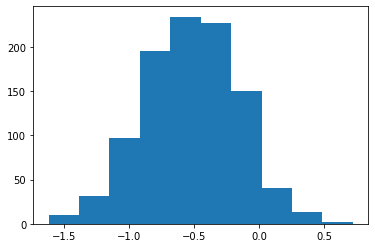

In [98]:
print(samples_test)
plt.hist(np.random.normal(samples_test[0], np.exp(samples_test[1]), size=1000))

2. (**Variational Inference for BNNs**) For the Bayesian model you implemented in Exercise 1, use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!

In [135]:
def variational_inference(Sigma_W, sigma_y, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        N = x_train.flatten().shape[0] 
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - nn.forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = nn.weights[0]
    print(D)
    print(nn.weights.shape)
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    print(init_var_params.shape)
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

In [136]:
print(nn.weights[0])

[ 1.78542114  0.49826634  0.72049908  2.28715108  1.62908673  2.32327146
  2.87083028 -2.24918169  3.92402928 -0.51376547 -0.4217357   3.10323303
  1.10115717 -0.65003734  0.17082128 -3.38028344]


In [140]:
sigma_diagonal = 25
Sigma = sigma_diagonal*np.eye(nn.D)
sigma_y = 0.5
posterior_vi = variational_inference(Sigma, sigma_y, y_train, x_train, S=10, max_iteration=50000, step_size=1e-2, verbose=True)

Optimizing variational parameters...
16
(1, 16)
(32,)
Iteration 0 lower bound -1625.879106325607; gradient mag: 4.013795920762356
Iteration 100 lower bound -1609.8448622159103; gradient mag: 4.306954016107002
Iteration 200 lower bound -1593.8131247166496; gradient mag: 4.009766098415407
Iteration 300 lower bound -1577.777610523347; gradient mag: 4.0092082795597275
Iteration 400 lower bound -1561.7406923766075; gradient mag: 4.009114845321653
Iteration 500 lower bound -1545.7036378456148; gradient mag: 4.008879502065232
Iteration 600 lower bound -1529.667373828533; gradient mag: 4.008358486628971
Iteration 700 lower bound -1513.632662193283; gradient mag: 4.007619713755557
Iteration 800 lower bound -1497.6000753300036; gradient mag: 4.00677905382237
Iteration 900 lower bound -1481.5699809822272; gradient mag: 4.005928173816195
Iteration 1000 lower bound -1465.5425620588237; gradient mag: 4.005122600673984
Iteration 1100 lower bound -1449.5178533371882; gradient mag: 4.004390481977855
It

Iteration 10300 lower bound -58.579563145789734; gradient mag: 145.71416515115044
Iteration 10400 lower bound -61.62583091914737; gradient mag: 130.89974318470874
Iteration 10500 lower bound -55.65264725141303; gradient mag: 42.58881407005694
Iteration 10600 lower bound -55.406302626188335; gradient mag: 154.0573672626756
Iteration 10700 lower bound -57.17287348856948; gradient mag: 72.14458635569785
Iteration 10800 lower bound -57.203447834952115; gradient mag: 44.298778796103285
Iteration 10900 lower bound -56.96226958238489; gradient mag: 79.67911542308882
Iteration 11000 lower bound -57.245952881328954; gradient mag: 79.67084568383942
Iteration 11100 lower bound -53.91508562997636; gradient mag: 60.02145065232329
Iteration 11200 lower bound -55.46743520677657; gradient mag: 60.6147624080876
Iteration 11300 lower bound -55.60130481017753; gradient mag: 163.23520978789247
Iteration 11400 lower bound -56.08143710465662; gradient mag: 30.278463520733958
Iteration 11500 lower bound -59.

Iteration 20500 lower bound -53.23604592540059; gradient mag: 31.510844721527754
Iteration 20600 lower bound -54.89027126434013; gradient mag: 94.93414336649107
Iteration 20700 lower bound -54.2809982179445; gradient mag: 24.189537243966225
Iteration 20800 lower bound -53.528997221321234; gradient mag: 30.72873909564635
Iteration 20900 lower bound -53.07824897078456; gradient mag: 34.676560169207775
Iteration 21000 lower bound -52.997616617968305; gradient mag: 74.36670777515003
Iteration 21100 lower bound -51.13646901718573; gradient mag: 11.825623898797462
Iteration 21200 lower bound -53.97969560196756; gradient mag: 17.422083498224474
Iteration 21300 lower bound -53.927690054578974; gradient mag: 13.420656191055118
Iteration 21400 lower bound -52.57699611723522; gradient mag: 171.71423247404223
Iteration 21500 lower bound -54.730847123331685; gradient mag: 126.03440854820988
Iteration 21600 lower bound -50.96202574511838; gradient mag: 10.796423580528119
Iteration 21700 lower bound 

Iteration 30700 lower bound -48.62691464530741; gradient mag: 63.68280375482005
Iteration 30800 lower bound -49.33329509852983; gradient mag: 37.165889773144876
Iteration 30900 lower bound -48.785150477275906; gradient mag: 30.903498551377822
Iteration 31000 lower bound -49.40382143401316; gradient mag: 12.045676434032593
Iteration 31100 lower bound -46.47531491545958; gradient mag: 15.089315614944063
Iteration 31200 lower bound -48.81526204378704; gradient mag: 19.928732404648077
Iteration 31300 lower bound -46.65031466385855; gradient mag: 8.059002472022856
Iteration 31400 lower bound -47.27616843644831; gradient mag: 11.020810828848
Iteration 31500 lower bound -47.517771090858865; gradient mag: 197.73506503596622
Iteration 31600 lower bound -47.10138384117397; gradient mag: 192.2675424832535
Iteration 31700 lower bound -47.582952023492474; gradient mag: 9.835885525250081
Iteration 31800 lower bound -46.958354853645446; gradient mag: 22.82027268778772
Iteration 31900 lower bound -46.

Iteration 40900 lower bound -45.8637472654791; gradient mag: 19.647219663112484
Iteration 41000 lower bound -48.31986313214113; gradient mag: 10.185948516765261
Iteration 41100 lower bound -46.70916883260514; gradient mag: 42.350446560364944
Iteration 41200 lower bound -47.33616972317034; gradient mag: 42.702276826419954
Iteration 41300 lower bound -46.70350130486046; gradient mag: 6.1774980911286015
Iteration 41400 lower bound -47.55057478813665; gradient mag: 13.70763978985917
Iteration 41500 lower bound -46.64121531406047; gradient mag: 18.21146122732494
Iteration 41600 lower bound -46.43435168669441; gradient mag: 50.716127415033235
Iteration 41700 lower bound -47.35162451868757; gradient mag: 12.274978037245097
Iteration 41800 lower bound -47.018163591893995; gradient mag: 21.896615312457172
Iteration 41900 lower bound -46.89055080536079; gradient mag: 8.94070780602379
Iteration 42000 lower bound -46.95301398002828; gradient mag: 14.112050982176404
Iteration 42100 lower bound -46.

In [141]:
samples = np.random.multivariate_normal(mean = posterior_vi[:nn.D], cov = np.diag(np.exp(posterior_vi[nn.D:])), size=100)

3. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1))) 
y_test += np.random.normal(0, 0.5, size=y_test.shape)
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.

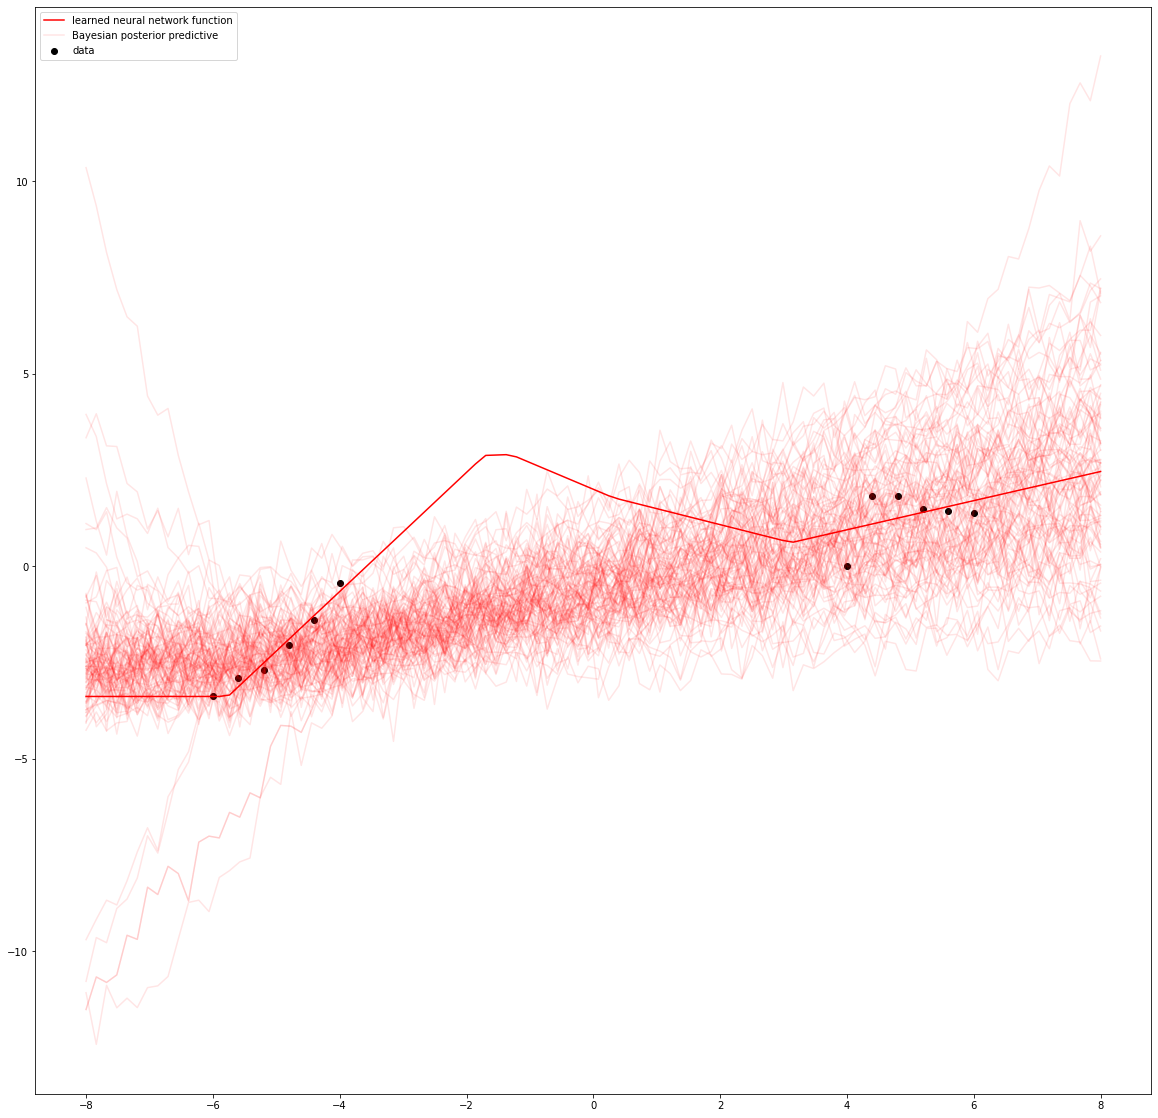

In [144]:
y_test_pred = nn.forward(nn.weights, x_test.reshape((1, -1)))
#visualize the function learned by the neural network
fig, ax = plt.subplots(1, figsize = (20, 20))
ax.scatter(x_train.flatten(), y_train.flatten(), color='black', label='data')
ax.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
for sample in samples:
    x_test = np.linspace(-8, 8, 100)
    y_test = nn.forward(sample.reshape(1, -1), x_test.reshape((1, -1))) 
    y_test += np.random.normal(0, 0.5, size=y_test.shape)
    ax.plot(x_test.flatten(), y_test.flatten(), alpha = 0.1, color='red')
ax.plot(x_test.flatten(), y_test.flatten(), alpha = 0.1, color='red', label='Bayesian posterior predictive')
plt.legend(loc='best')
plt.show(fig)

4. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 

$$
  \log \prod_{n=1}^N \int_{W} p(Y^{\text{Obs}}_n | W) p(W|Y^{\text{Obs}}_1, \ldots, Y^{\text{Obs}}_N) dW \approx \sum_{n=1}^N\log \frac{1}{S} \sum_{s=1}^S p(Y^{\text{Obs}}_n | W^s), 
  $$

In [147]:
def log_post_lklhd(W, sigma_y, x_train, y_train):
        S = W.shape[0]
        N = x_train.flatten().shape[0] 
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - nn.forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential

### Part III: Comparison 

1. (**Model Evaluation**) Compare the posterior predictive visualization and the posterior predictive log likelihood obtained from BBVI with the reparametrization trick to the ones you obtained using HMC. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?

For BBVI: 
- The posterior predictive looks different than the one obtained with HMC. Indeed, BBVI does not seem to capture the epistemic uncertainty (and OOD uncertainty in the central region). It however does capture the epistemic uncertainty at the boundaries of the domain
- The predictive log likehood are both high. This is due to the fact that the log-likelihood takes care of the **observed data**, where both of our models are pretty confident. 

The approximation of the posterior in BBVI tends to kill the estimation of epistemic uncertainty. THe Mean-Field Gaussian Family does not seem to be able to capture the OOD uncertainty.

2. (**Quality of Posterior Vs Quality of Posterior Predictive**) Based on your convergence diagnostics of your HMC sampler, do you believe that you've obtained a set of representative samples from the BNN posterior? Why or why not? 

  Based on your understanding of BNN posteriors, do you believe that a mean-field Gaussian is a good approximation of the BNN posterior? Why or why not?

  Which set of samples, HMC or VI, do you believe better captures the BNN posterior?

  Based on the empirical results from above, do you believe there is a clear positive relationship between posterior approximation and quality of posterior predictive uncertainties - i.e. is it true that the more I capture of the BNN posterior the beter the quality of my posterior predictive uncertainties?

Yes, I do believe that I have not yet obtained a set of representative samples from the BNN posterior. 
There might be several reasons for that:
- The initial parameters of the log_std are arbitray. 
- We might vary the learning rate and the size S chosen for computing Monte-Carlo estimates of the expectancies.
- The limitations of BNN using BBVI

The BNN posteriors involve correlation that mean-field Gaussian are not able to capture. In that way, the Mean-Field Gaussian presents intrinsic components that are rough approximations of the truth. 

I do not think there is any clear relationship between posterior approximation and quality of posterior predictive uncertainties. 

3. (**Speed and Scalability**) Compare the two inference methods, HMC and BBVI, and discuss the scalability of each with respect to the number of model parameters and number of data points (how does increasing the number of model parameters or the number of data points affect each inference method?). 

BBVI is way more scalable.